# Signals and Systems Project - Spring 2022-2023 semester

## The first part of the project: Implementation of image compression

<div dir="ltr ">
    Suppose you want to compress a photo. For this, you first remove or dim the parameters that the human eye is less sensitive to. If we break down an image into its frequency components, the human eye pays less attention to high frequencies. So, by removing these frequencies, the size of the image can be reduced, and this is the idea of the inventors of the JPEG format. Now we want you to compress a photo step by step and restore it back to its original state. For convenience, we assume the input image is black and white.
<br>
   <img src="https://www.researchgate.net/profile/Jacinta-Oshea-2/publication/7232959/figure/fig2/AS:282593288310787@1444386898429/High-and-low-spatial-frequency-information-Images-contain-different-spatial-frequencies_W640.jpg" alt="Drawing" style="width: 600px;"/>
    <center<br</center>

</div>

<div dir="ltr">

### step 0: libraries<br>
The required libraries for the project are listed below
If you need another library, add it and explain why you need it.

</div>

In [23]:
import numpy as np
import cv2 as cv #install using pip: "pip install opencv-python"
import matplotlib.pyplot as plt
import seaborn as sns #install using pip: "pip install seaborn"

<div dir="rtl">

### step 1: read images<br>
In this step, we read the desired photo using cv2. Because we open the image in grayscale, the image will be a two-dimensional array, each element of which represents the brightness of a pixel.

</div>

(1000, 900)


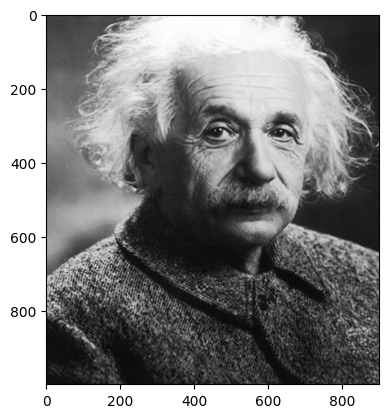

In [2]:
image_path = 'face1.png'
image = cv.imread(image_path, cv.IMREAD_GRAYSCALE)
print(image.shape) #height, width
plt.imshow(image, cmap='gray')
plt.show()

<div dir="rtl">

### step 2: split images to 8x8 patches<br>
divide 8x8 and extract longitudinal and transverse frequency components in each of these parts and decide which one to remove. So, write a function that by taking a photo, outputs its 8x8 squares in the form of a list (in order from 0,0 to the last house). The length and width of the photo were not divisible by 8, assume the rest of the houses to be zero.

</div>

In [94]:
def extract_squares(image):
    #############  TODO #############
    #your code
    
    height, width = image.shape
    delta_height, delta_width = 0, 0


    if height % 8 != 0:
      delta_height = ((height // 8) + 1) * 8 - height

    if width % 8 != 0:
      delta_width = ((width // 8) + 1) * 8 - width

    image = np.concatenate((image, np.zeros((delta_height, image.shape[1]))), axis = 0)
    image = np.concatenate((image, np.zeros((image.shape[0], delta_width))), axis = 1)



    results = []
    for i in range(image.shape[0] // 8):
      for j in range(image.shape[1] // 8):
        I = i * 8
        J = j * 8
        results.append(image[I:I + 8, J:J + 8])

    return np.array(results)

<div dir="rtl">

### step 3: Discrete Cosine Transform<br>
Let's use DCT for our 8x8. First, write a function that performs DCT-II on a one-dimensional signal. The following relationship gives you the cosine transform coefficients.([Wikipedia](https://en.wikipedia.org/wiki/Discrete_cosine_transform#DCT-II))<br>
$${\displaystyle X_{k}=\sum _{n=0}^{N-1}x_{n}\cos \left[\,{\tfrac {\,\pi \,}{N}} \left(n+{\tfrac {1}{2}}\right)k\,\right]\qquad {\text{ for }}~k=0,\ \dots \ N-1~.}$$
</div>

In [95]:
def dct_1d(signal):
    #############  TODO #############
    #your code
    
    N = len(signal)
    transformed = []

    for k in range(N):
      result = 0
      for n in range(N):
        result += signal[n]*np.cos((np.pi * (n + 0.5) * k) / N)
      transformed.append(result)

    return np.array(transformed)

<div dir="ltr">

### step 4: transformation on matrix<br>
To get DCT on 8x8 matrix, first subtract 128 units from all the numbers of your matrix. In this way, your number range changes from ${(0,255)}$ to ${(-128,127)}$ and its fixed value is removed. Then, for two-dimensional DCT, implement DCT once on the length and once on the width of your function. You can do this with the `np.apply_along_axis` function.<br>
  <img src="https://upload.wikimedia.org/wikipedia/commons/2/24/DCT-8x8.png"/>
     <center> Above you can see the dct-II function in two dimensions. The light-to-dark gradient indicates the degree of the function from positive one to negative one.</center>
<br>
In addition to the method we implemented, DCT can also be implemented with matrix multiplication. For this, we need a transformation matrix like ${C}$. Then DCT is calculated using the following relation.([more details](https://fairyonice.github.io/2D-DCT.html))
     $${X = C x C^{T}}$$
</div>

In [96]:
def dct_2d(matrix):
    #############  TODO #############
    #your code
    
    m = matrix.copy()
    m -= 128
    ans1 = np.apply_along_axis(dct_1d, 0, m)
    ans2 = np.apply_along_axis(dct_1d, 1, ans1)

    return ans2

<div dir="ltr">

### step 5: Quantization<br>
Now that we have the coefficients, we want to eliminate the ones that are less important. For this, we use a quantization matrix. This matrix shows us to what extent we can discard the redundant coefficients.([Wikipedia](https://en.wikipedia.org/wiki/JPEG#Quantization))
Below is the matrix for qualities 10, 50 and 90. For compression, it is necessary to divide the matrix members obtained from DCT by their corresponding members in the Quantization matrix and round the obtained number.
</div>

In [97]:
quality_levels = {
        10: np.array([  [80, 60, 50, 80, 120, 200, 255, 255],
                        [55, 60, 70, 95, 130, 255, 255, 255],
                        [70, 65, 80, 120, 200, 255, 255, 255],
                        [70, 85, 110, 145, 255, 255, 255, 255],
                        [90, 110, 185, 255, 255, 255, 255, 255],
                        [120, 175, 255, 255, 255, 255, 255, 255],
                        [245, 255, 255, 255, 255, 255, 255, 255],
                        [255, 255, 255, 255, 255, 255, 255, 255]]),

        50: np.array([  [16, 11, 10, 16, 24, 40, 51, 61],
                        [12, 12, 14, 19, 26, 58, 60, 55],
                        [14, 13, 16, 24, 40, 57, 69, 56],
                        [14, 17, 22, 29, 51, 87, 80, 62],
                        [18, 22, 37, 56, 68, 109, 103, 77],
                        [24, 35, 55, 64, 81, 104, 113, 92],
                        [49, 64, 78, 87, 103, 121, 120, 101],
                        [72, 92, 95, 98, 112, 100, 103, 99]]),

        90: np.array([  [3, 2, 2, 3, 5, 8, 10, 12],
                        [2, 2, 3, 4, 5, 12, 12, 11],
                        [3, 3, 3, 5, 8, 11, 14, 11],
                        [3, 3, 4, 6, 10, 17, 16, 12],
                        [4, 4, 7, 11, 14, 22, 21, 15],
                        [5, 7, 11, 13, 16, 12, 23, 18],
                        [10, 13, 16, 17, 21, 24, 24, 21],
                        [14, 18, 19, 20, 22, 20, 20, 20]])
    }

In [98]:
def quantization(matrix, q_matrix):
    #############  TODO #############
    #your code
    
    return np.divide(matrix, q_matrix).astype(int)

<div dir="ltr">

### step 6: remove high frequency elements<br>
<img src="https://upload.wikimedia.org/wikipedia/commons/4/43/JPEG_ZigZag.svg" alt="Drawing" style="width: 400px;"/>

In this step, we read the matrix obtained from the previous step in a zigzag form (as in the figure above). With this, we should get a sequence of length 64. Now we delete the sequence from the last non-zero number onwards. After that, we write the sequence (we put a comma between two consecutive numbers) and we don't write any zero where we see it. (to reduce the length of our string.)
An example for the input and output of a 4x4 matrix is given below.

</div>

In [99]:
# input
#[  1,   5,   23,   0,
#  12, 119,    7,   0,
#   6,   0,    0,   0,
#   0,   8,    0,   0]
# sequence
# [1,5,12,6,119,23,0,7,0,0,8,0,0,0,0,0]
# removing last zeros
# [1,5,12,6,119,23,0,7,0,0,8]
# removing zeros in the middle and returning a string
# "1,5,12,6,119,23,,7,,,8"
def matrix_to_string(matrix):
    #############  TODO #############
    #your code
    
    sorted = zigzag(matrix)

    while len(sorted) > 0:
      if sorted[-1] == 0:
        del sorted[-1]
      else:
        break
        
    ans = ''
    for i in range(len(sorted)):
        if sorted[i] == 0:
            ans = ans + ','
        else:
            ans = ans + str(int(sorted[i])) + ','
        

    return ans[:len(ans)-1]


def zigzag(matrix):
  ans = []

  n = matrix.shape[0]
  for i in range(2 * n - 1):
    if i <= n - 1:
      if i % 2 == 0:
        for j in range(i, -1, -1):
          ans.append(matrix[j, i-j])
      else:
        for j in range(i + 1):
          ans.append(matrix[j][i-j])
    else:
      step = 2 * (n - 1) - i
      if i % 2 == 0:
        for j in range(n - 1, n - 2 - step, -1):
          ans.append(matrix[j][i - j])
      else:
        for j in range(n - 1, n - 2 - step, -1):
          ans.append(matrix[i - j][j])

  return ans

<div dir="ltr">

### step 7: compression<br>
At this stage, you should use all the functions that you wrote before, one after the other, so that we can finally compress a photo. In saving the file, write the quality factor and the length and width of the image that we need to decompress it.

</div>

In [100]:
def jpeg_comp(input_image_path, output_file_path, quality):
    # open the image
    image = cv.imread(input_image_path, cv.IMREAD_GRAYSCALE)
    #############  TODO #############
    # extraxt 8x8 squares
    # perform dct_2d on each one
    # quantize each one
    # turn each one into a string using zig zag method
    # write image size and quality into the output file
    # write each string generated by zig zag into a seperate line(ordered)
    
    height, width = image.shape
    squares = extract_squares(image)
    strings = []

    for matrix in squares:
      strings.append(matrix_to_string(quantization(dct_2d(matrix), quality_levels[quality])))

    file = open(output_file_path, 'w')
    file.write(f'{height} {width}\n')
    file.write(f'{quality}\n')

    for s in strings:
      file.write(s + '\n')

    file.close()

In [10]:
jpeg_comp('face1.png', 'compress.txt', 90)

<div dir="ltr">

#### hint<br>
Nowadays, in JPEG compression, two more steps are also passed:<br>
First step: If some of the numbers or symbols in our sequence are repeated, we put the number of repetitions multiplied by the symbol instead of the symbol. For example, if we have in our sequence
     $${1,1,1,1}$$
Instead we write:
     $${4\times 1}$$<br>
Second step: we use huffman coding. That is, we map the substrings that are repeated more to shorter strings and those that are repeated less often to longer strings. By doing this, the length of our whole string is reduced. Finally, we add this map to the file so that we can return the string produced by huffman coding to the original string. ([Wikipedia](https://en.wikipedia.org/wiki/Huffman_coding)) >
But since your lesson is not about compression algorithms, these two parts are omitted from your project.
</div>

<div dir="ltr">

### step 8: convert string to matrix<br>
Construct it by taking a corresponding 8x8 matrix string.
</div>

In [101]:
def string_to_matrix(string):
    #############  TODO #############
    #your code
    
    result = []
    number_str = string.split(',')

    for x in number_str:
      if x == '':
        result.append(0)
      else:
        result.append(int(x))

    while len(result) < 64:
      result.append(0)

    return zigzag_fill(result)


def zigzag_fill(numbers):
  ans = np.zeros((8, 8))

  index = 0
  for i in range(15):
    if i <= 7:
      if i % 2 == 0:
        for j in range(i, -1, -1):
          ans[j, i-j] = numbers[index]
          index += 1
      else:
        for j in range(i + 1):
          ans[j][i-j] = numbers[index]
          index += 1
    else:
      step = 2 * 7 - i
      if i % 2 == 0:
        for j in range(7, 7 - step - 1, -1):
          ans[j][i - j] = numbers[index]
          index += 1
      else:
        for j in range(7, 7 - step - 1, -1):
          ans[i - j][j] = numbers[index]
          index += 1

  return ans

<div dir="ltr">

### step 9:Dequantization<br>
In order to eliminate the effect of the quantization matrix, this time it is enough to multiply the elements in that matrix.
</div>

In [102]:
def dequantization(matrix, q_matrix):
    #############  TODO #############
    #your code
    
    return np.multiply(matrix, q_matrix)

<div dir="ltr">

### step 10: IDCT<br>
Write the inverse cosine transform first in one dimension and then in two dimensions (add the value 128 to it after the transformation). ([Wikipedia](https://en.wikipedia.org/wiki/Discrete_cosine_transform#Inverse_transforms))

</div>

In [103]:
def idct_1d(signal):
    #############  TODO #############
    #your code
    
    N = len(signal)
    transformed = []
    for k in range(N):
        result = 0
        for n in range(1, N):
            result += signal[n]*np.cos((np.pi * (k + 0.5) * n) / N)
        result += 0.5 * signal[0]
        result *= 2 / N
        transformed.append(result)
        
    return np.array(transformed)


def idct_2d(matrix):
    #############  TODO #############
    #your code
    
    ans1 = np.apply_along_axis(idct_1d, 0, matrix)
    ans2 = np.apply_along_axis(idct_1d, 1, ans1)

    ans2 += 128

    return ans2

<div dir="ltr">

### step 11: create image<br>
With the length and width of the photo and the obtained matrices, make the photo!
</div>

In [104]:
def merge_squares(matrices, height, width):
    #############  TODO #############
    #your code
    
    h = height
    w = width


    if height % 8 != 0:
      h = ((height // 8) + 1) * 8

    if width % 8 != 0:
      w = ((width // 8) + 1) * 8


    ans = np.zeros((h, w))
    k = 0
    for i in range(h // 8):
      for j in range(w // 8):
        I = i * 8
        J = j * 8
        ans[I:I+8, J:J+8] = matrices[k]
        k += 1

    return ans

<div dir="ltr">

### step 12: decompression<br>
Reconstruct the picture of the previous part by collecting the functions next to each other.
</div>

In [105]:
def jpeg_decomp(input_file_path, output_image_path):
    #############  TODO #############
    # open the file
    # get quality, width and height
    # get image data as a list of strings
    # turn string into matrices with zig zag method
    # dequantize
    # perform idct_2d
    # put 8x8 pieces together
    # write the image into the output
    
    file = open(input_file_path, 'r')

    txt = file.read()

    file.close()

    info = txt.split('\n')

    height, width = int(info[0].split(' ')[0]), int(info[0].split(' ')[1])

    quality = int(info[1])

    strings = info[2: len(info) - 1]

    matrices = []

    for s in strings:
      matrices.append(idct_2d(dequantization(string_to_matrix(s), quality_levels[quality])))

    matrices = np.array(matrices)
    image = merge_squares(matrices, height, width)

    image[image > 255] = 255
    image[image < 0] = 0
    cv.imwrite(output_image_path, image)

    return image

In [11]:
new_image = jpeg_decomp('compress.txt', 'face2.jpeg')

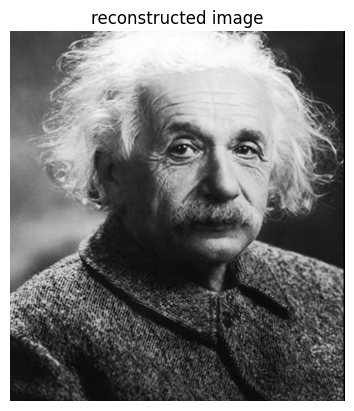

In [14]:
plt.imshow(new_image, cmap='gray')
plt.axis('off')
plt.title('reconstructed image')
plt.show()

<div dir="ltr">

### first question:<br>
To better understand Q-tables, select 5 random 8x8 squares from your image. Perform the DCT conversion and draw their Heatmaps in order.
</div>

In [17]:
def plot_random_blocks(n, array, indices=None):
    """
    Inputs:
        n: Number of blocks to plot
        array: A list of blocks
        indices: If None, a random indices whould be selected to plot; otherwise plot the given indecies

    Output:
        indices: returns the ploted indices
    """
    num_blocks = array.shape[0]

    # Generate random indices for selecting blocks if indices is None
    if np.any(indices == None):
        indices = np.random.choice(num_blocks, n, replace=False)

    # Create a subplot grid for plotting the heatmaps
    num_cols = int(np.ceil(np.sqrt(n)))
    num_rows = int(np.ceil(n / num_cols))
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(12, 12))

    # Plot each block as a heatmap using Seaborn
    for i, idx in enumerate(indices):
        row_idx = i // num_cols
        col_idx = i % num_cols
        block = array[idx]
        sns.heatmap(block, cmap='hot', ax=axes[row_idx, col_idx], cbar=False, annot=True, fmt=".1f")
        axes[row_idx, col_idx].set_title(f"Block {idx} Heatmap")
        axes[row_idx, col_idx].axis('off')

    # Adjust spacing between subplots and display the plot
    fig.tight_layout()
    plt.show()

    # Retuen ploted indices
    return indices

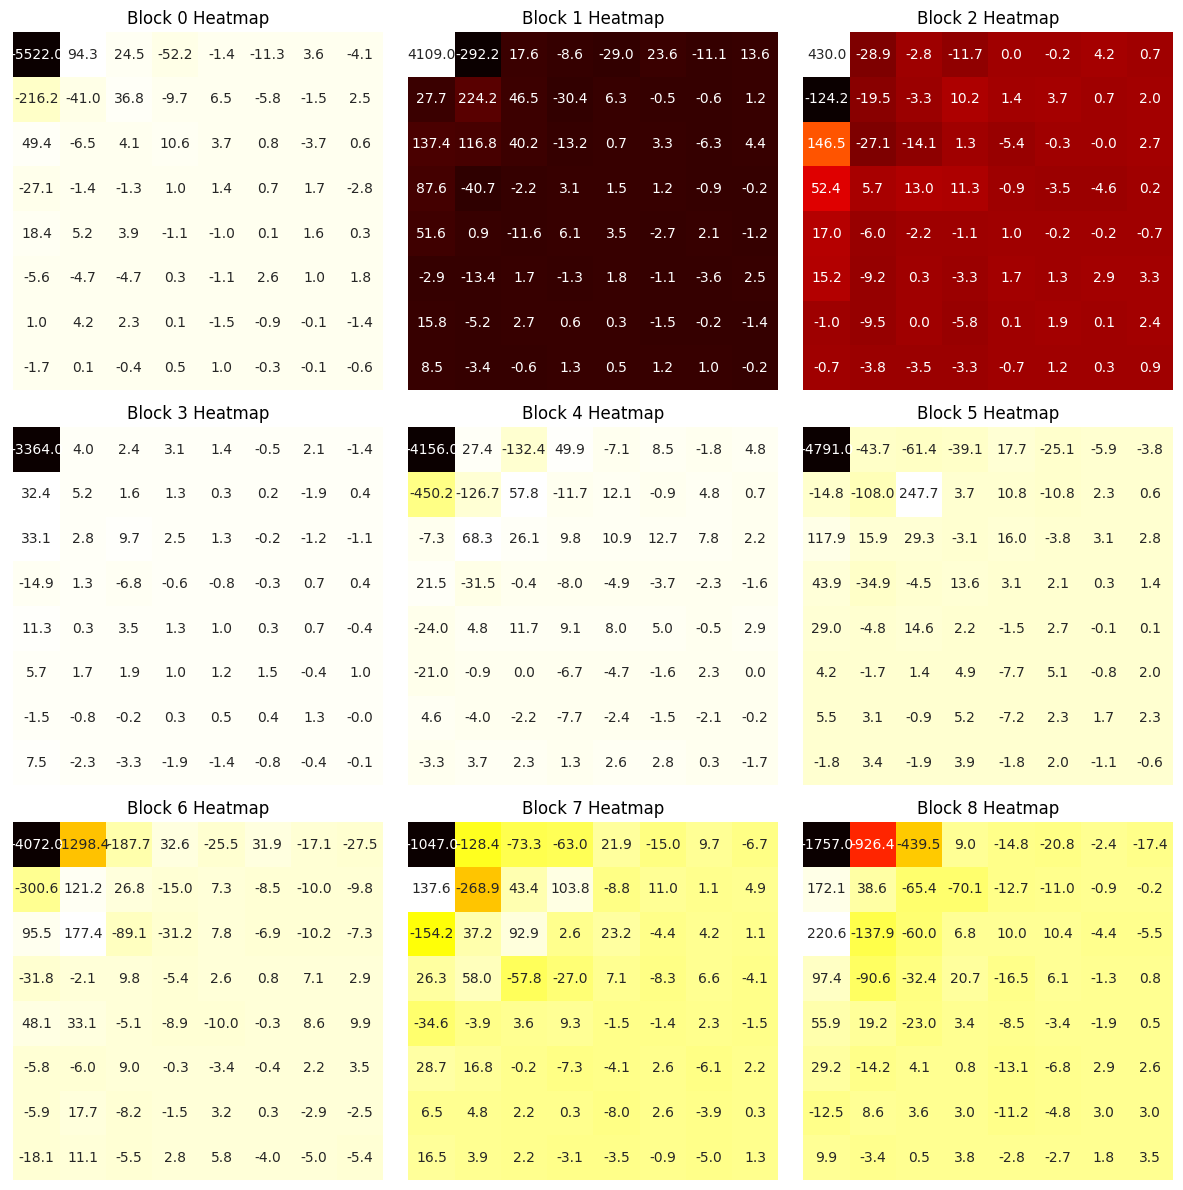

[0, 1, 2, 3, 4, 5, 6, 7, 8]

In [18]:
#your code

#############  TODO #############
#your code

squares = extract_squares(image)
indexes = np.random.choice(list(range(len(squares))), 9, replace=False)

choosed = np.array([squares[x] for x in indexes])

dct = np.array([dct_2d(x) for x in choosed])

plot_random_blocks(9, dct, list(range(9)))

<div dir="rtl">
اکنون به ترتیب Quantization و Dequantization را روی هر کدام با کیفیت 90 انجام دهید و در زیر Heatmap آنها را رسم کنید.
</div>

In [19]:
#your code
#############  TODO #############
#your code

quant = np.array([quantization(x, quality_levels[90]) for x in dct])

dequant = np.array([dequantization(x, quality_levels[90]) for x in quant])

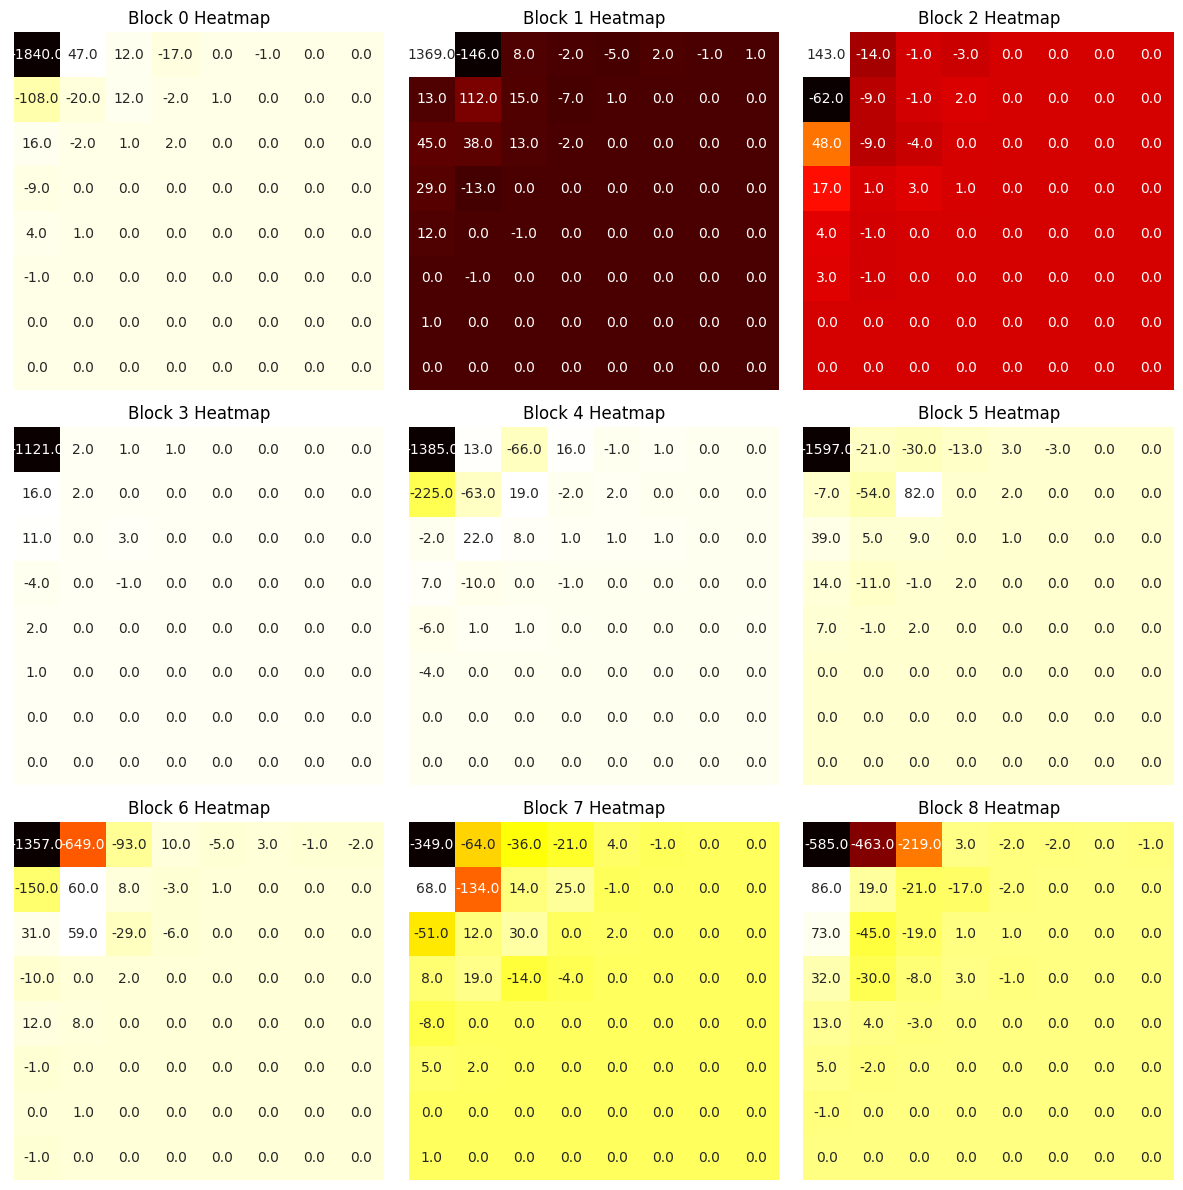

[0, 1, 2, 3, 4, 5, 6, 7, 8]

In [20]:
plot_random_blocks(9, quant, list(range(9)))

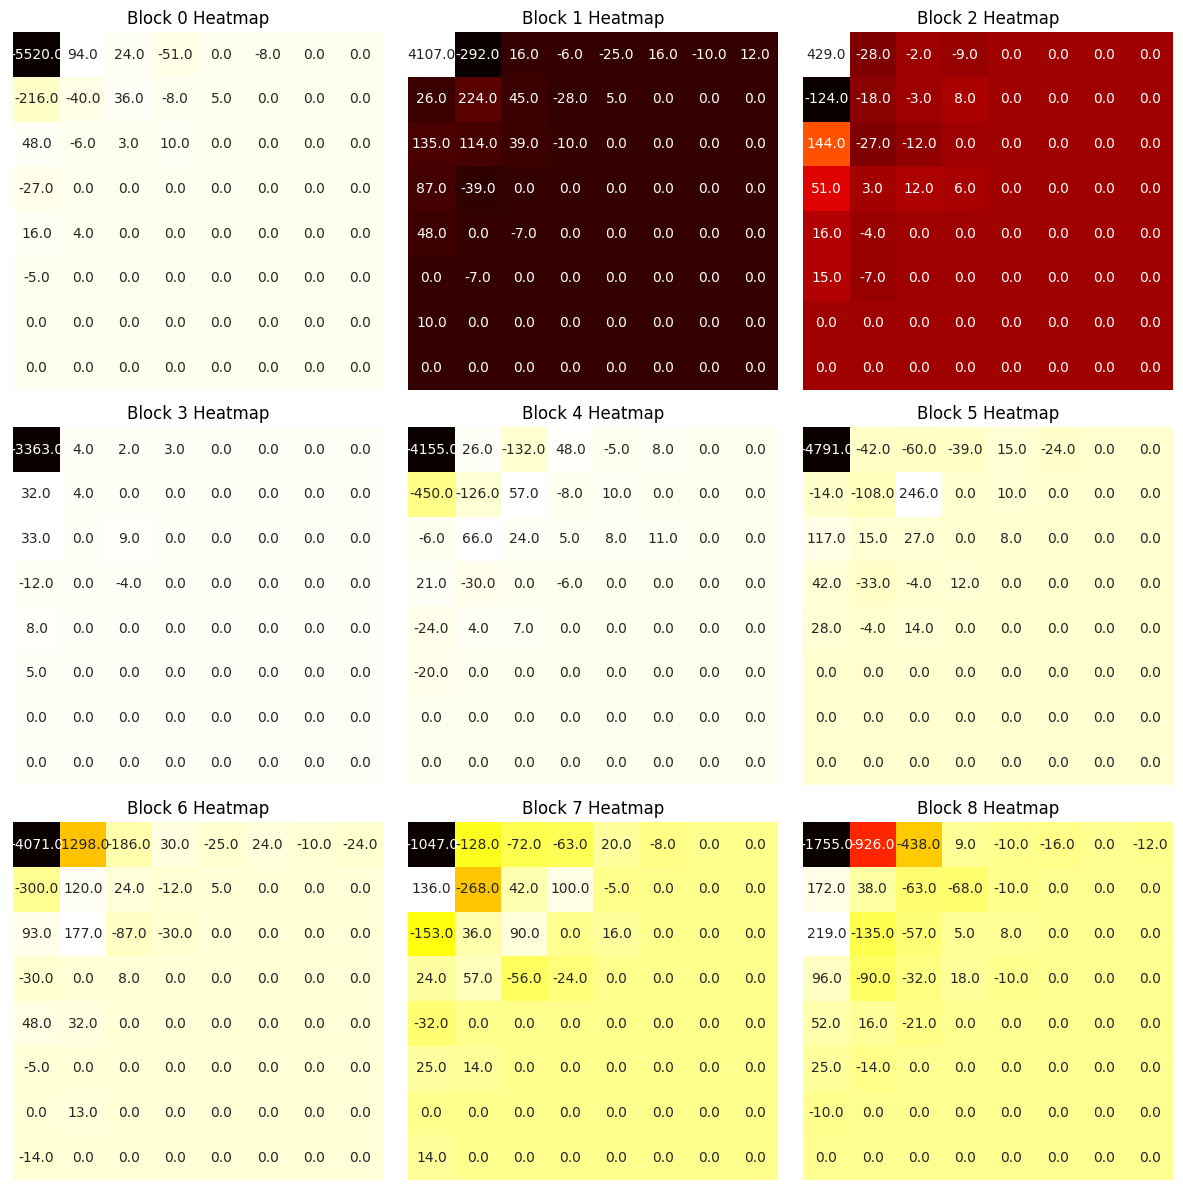

[0, 1, 2, 3, 4, 5, 6, 7, 8]

In [21]:
plot_random_blocks(9, dequant, list(range(9)))

<div dir="rtl">
عملیات مرحله قبل را با کیفیت 10 انجام دهید.
</div>

In [22]:
#############  TODO #############
#your code

quant = quantization(dct, quality_levels[10])

dequant = np.array([dequantization(x, quality_levels[10]) for x in quant])

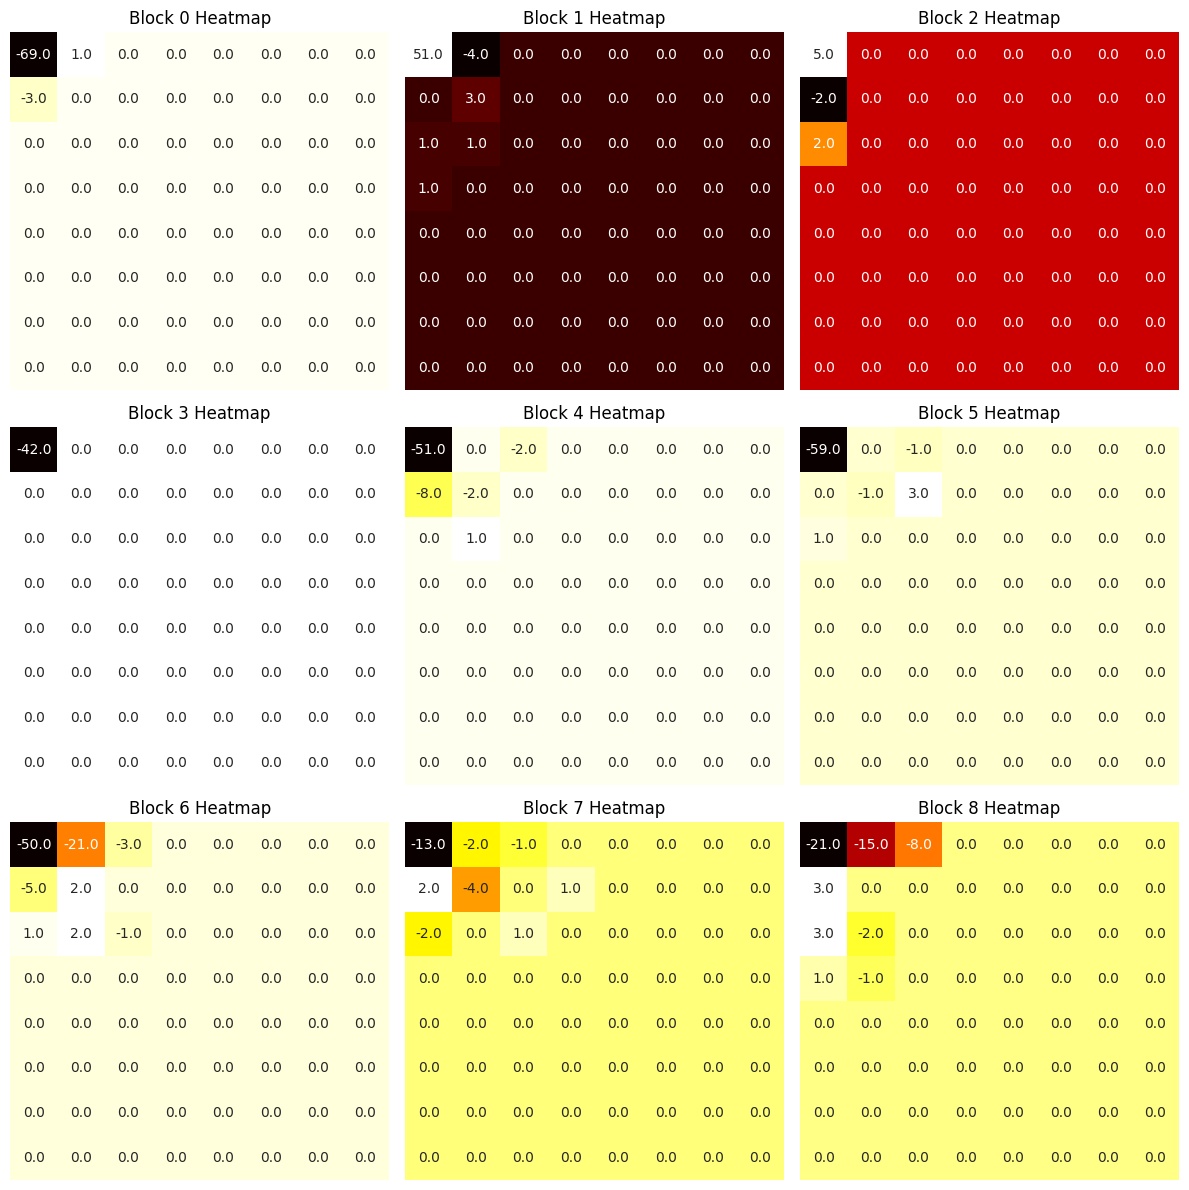

[0, 1, 2, 3, 4, 5, 6, 7, 8]

In [23]:
plot_random_blocks(9, quant, list(range(9)))

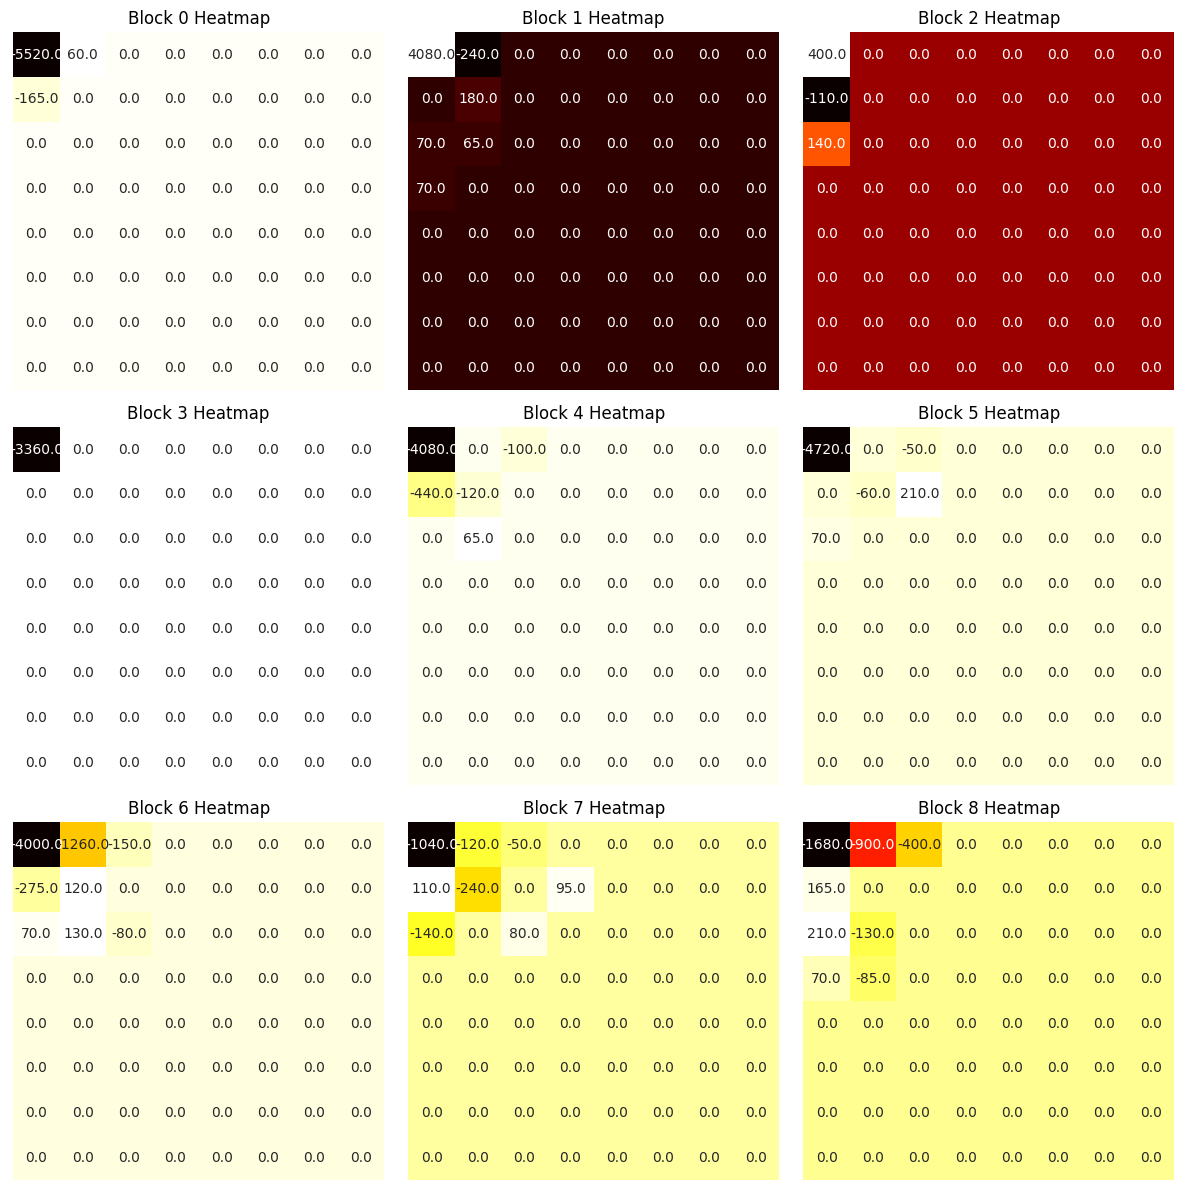

[0, 1, 2, 3, 4, 5, 6, 7, 8]

In [24]:
plot_random_blocks(9, dequant, list(range(9)))

<div dir="ltr">
Calculate 8x8 in each of the above steps. By looking at these numbers, you can conclude how JPEG compresses photos and why the quality decreases with more compression.</div>

<div dir="ltr">
When we compare the number of zeros in the quantized matrices for quality 10 and 90, we notice that the number of zeros in quality 10 is far more than the number of zeros in quality 90. If we pay attention to the numbers in these matrices, we will notice that the numbers in the 10 quality matrix are larger than the numbers in the 90 quality matrix. As a result, if we use quality 10, a larger range of numbers in the 8x8 matrix, or in other words, a larger range of frequencies will be removed in this case, and when we want to get these numbers again, the numbers in these pixels will still remain zero. will remain and as a result in quality 10 the quality of the restored image will be lower than quality 90.
</div>

<div dir="ltr">

### second question:<br>
Convert the given photo to jpeg with three qualities of 10, 50 and 90, restore and save the restored files. (use formats that do not have compression by themselves)

</div>

In [26]:
#############  TODO #############
#your code

jpeg_comp('face1.png', 'compress_90.txt', 90)
jpeg_comp('face1.png', 'compress_50.txt', 50)
jpeg_comp('face1.png', 'compress_10.txt', 10)

image_90 = jpeg_decomp('compress_90.txt', 'face_90.jpeg')
image_50 = jpeg_decomp('compress_50.txt', 'face_50.jpeg')
image_10 = jpeg_decomp('compress_10.txt', 'face_10.jpeg')

In [16]:
image_90 = jpeg_decomp('compress_90.txt', 'face_90.jpeg')
image_50 = jpeg_decomp('compress_50.txt', 'face_50.jpeg')
image_10 = jpeg_decomp('compress_10.txt', 'face_10.jpeg')

<div dir="ltr">

Now display the restored files and the original file, find the absolute value difference of each pixel of the reconstructed images with the corresponding pixel in the original image (L1-Norm) and plot the result for the three qualities.

</div>

Text(0.5, 1.0, 'absolute difference')

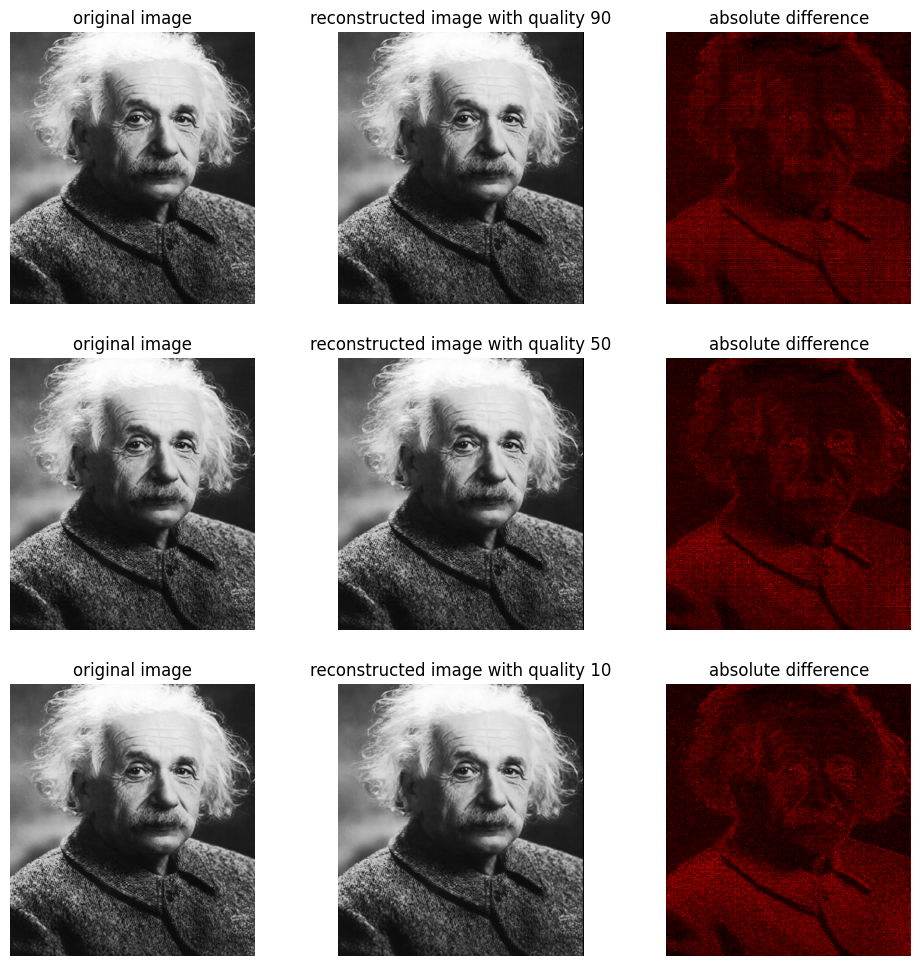

In [17]:
#############  TODO #############
#your code

fig = plt.figure(figsize=(12, 12))

fig.add_subplot(3, 3, 1)
plt.imshow(image, cmap='gray')
plt.axis('off')
plt.title('original image')

fig.add_subplot(3, 3, 2)
plt.imshow(image_90, cmap='gray')
plt.axis('off')
plt.title('reconstructed image with quality 90')

fig.add_subplot(3, 3, 3)
plt.imshow(np.abs(image - image_90[:, :900]), cmap = 'hot')
plt.axis('off')
plt.title('absolute difference')

fig.add_subplot(3, 3, 4)
plt.imshow(image, cmap='gray')
plt.title('original image')
plt.axis('off')


fig.add_subplot(3, 3, 5)
plt.imshow(image_50, cmap='gray')
plt.axis('off')
plt.title('reconstructed image with quality 50')

fig.add_subplot(3, 3, 6)
plt.imshow(np.abs(image - image_50[:, :900]), cmap = 'hot')
plt.axis('off')
plt.title('absolute difference')

fig.add_subplot(3, 3, 7)
plt.imshow(image, cmap='gray')
plt.title('original image')
plt.axis('off')


fig.add_subplot(3, 3, 8)
plt.imshow(image_10, cmap='gray')
plt.axis('off')
plt.title('reconstructed image with quality 10')

fig.add_subplot(3, 3, 9)
plt.imshow(np.abs(image - image_10[:, :900]), cmap = 'hot')
plt.axis('off')
plt.title('absolute difference')

<div dir="ltr">

Get the value of mean squared error for three qualities, write down the size of the compressed files and approximate the size of the files depending on their quality with a relationship (linear or degree 2). Briefly write your answer below.

</div>

<div dir="ltr">
The results of this section are calculated and shown in the cell below.</div>

In [18]:
mse_90 = np.mean((image - image_90[:, :900])**2)

mse_50 = np.mean((image - image_50[:, :900])**2)

mse_10 = np.mean((image - image_10[:, :900])**2)

print(f'mse error for quality 90: {mse_90:.2f}')
print(f'mse error for quality 50: {mse_50:.2f}')
print(f'mse error for quality 10: {mse_10:.2f}')

mse error for quality 90: 0.55
mse error for quality 50: 2.42
mse error for quality 10: 12.87


<div dir="ltr">
First, we draw the error graph according to Kiffin for these three data, and as it is clear, these data do not have a linear relationship, and it is better to fit the same 2nd degree relationship on these data.
</div>

Text(0.5, 1.0, 'plot of mse versus quality')

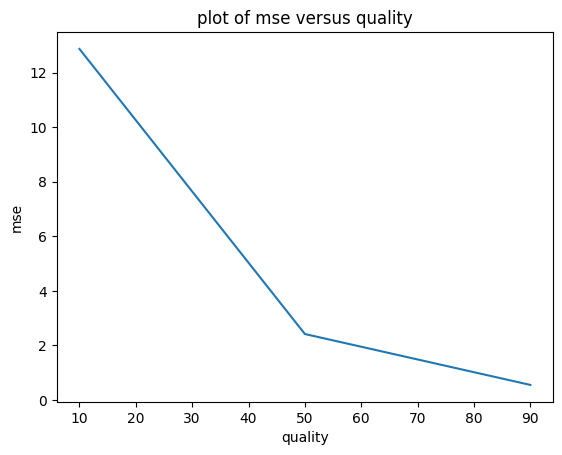

In [20]:
y = [mse_10, mse_50, mse_90]
x = [10, 50, 90]

plt.plot(x, y)
plt.ylabel('mse')
plt.xlabel('quality')
plt.title('plot of mse versus quality')

<div dir="ltr">
Now, using the plyfit method, a binomial function is fitted to this data (of course, the method outputs the coefficients of the binomial function) and finally, this function is drawn in the next diagram.

</div>

In [22]:
coeff = np.polyfit(x, y, 2)

Y = []

X = [i for i in range(10, 100, 10)]

for z in X:
    Y.append(coeff[0] * (z **2) + coeff[1] * z + coeff[2])

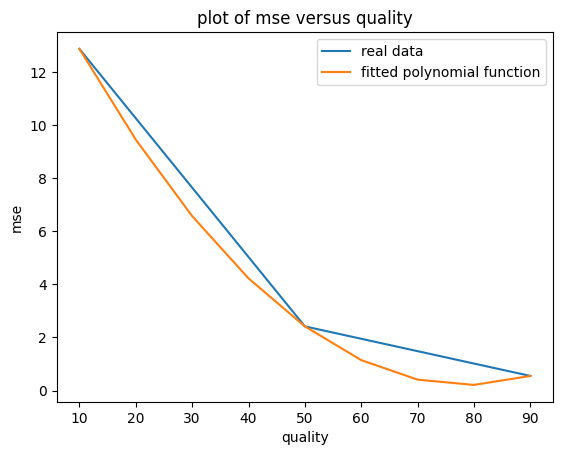

In [26]:
plt.plot(x, y, label='real data')
plt.plot(X, Y, label='fitted polynomial function')

plt.ylabel('mse')
plt.xlabel('quality')
plt.title('plot of mse versus quality')
plt.legend(loc='best')

<div dir="ltr">

### third question:<br>
You learned DFT in your lesson. In this question, we want to convert the DFT coefficients to DCT-II so that you can learn more about this conversion.<br>
Consider the first sequence below with length ${n}$ and the second sequence with length ${2n}$. Assume that the DCT-II coefficients of the first sequence are equal to ${d_{k}}$ and the DFT coefficients of the second sequence are equal to ${c_{k}}$. Get the value of ${c_{k}}$ from ${d_{k}}$.
     $${x_1,x_2,x_3,...,x_n}$$
     $${x_1,x_2,x_3,...,x_n,0,0,...,0}$$
</div>

<div dir="ltr">
First, I get $c_k$:
</div>

$$c_k = \sum_{n = 0}^{2N - 1} x_n e^{-jk \frac{2\pi}{2N}n} = \sum_{n = 0}^{N - 1} x_n e^{-jk \frac{\pi}{N}n}$$

<div dir="ltr">
Now I get $d_k$:
</div>

$$d_k = \sum_{n = 0}^{N-1} x_n cos(\frac{\pi k (2n + 1)}{2N}) = \frac{1}{2} e^{j\ frac{k\pi}{2N}} \sum_{n = 0}^{N-1} x_n e^{jk\frac{\pi}{N}n} + \frac{1}{2} e^ {-j\frac{k\pi}{2N}} \sum_{n = 0}^{N-1} x_n e^{-jk\frac{\pi}{N}n}$$

<div dir="ltr">
Now, if we assume that the series of $x_n$ are real numbers, then $c_k$ in terms of $d_k$ can be written as follows:
</div>

$$c_k = \frac{1}{2} Re\{e^{j \frac{k \pi}{2N}} d_k\}$$

## <center>second part: denosing!</center>

<div dir="ltr">

### target:

To send a signal from one place to another, we need a channel. In an ideal channel, the input and output signals are equal. As you know, there is no ideal channel in the real world! Signals are distorted. Noise falls on them and part of them is lost. Electrical, computer, mechanical, chemical and material science engineers and scientists are always looking for better communication channels. <br> But these problems can be cleverly bypassed. By knowing the type of channel, before sending the signal, changes can be applied to the signal opposite to what happens in the channel, so that after the signal passes through the channel, minimal damage will be done to our signal.

</div>

<div dir="ltr">

Your task is to design a function for each of the following channels that works inversely to the channel and by inputting the output of your function to the channel, the output image of the channel will be the primary image. In simpler words, your function should be the inverse function of the channel.

</div>

<div dir="ltr">

### your tools:<br>
You can enter the channels and see the output, and if you make a special conclusion, explain it by adding the shape of your input and output.<br>
To give input and output, just run the channel with python or python3 and give the path to your file as an argument.<br>
In addition to the output itself, you can also see its DCT conversion and compare it to the input. In real telecommunication channels, the frequency behavior of the channel is extremely important, and here you will also get to know this feature of the channel. The `scipy.fftpack' library has a one-dimensional DCT transform, with your knowledge from the first part of the project, build and use a two-dimensional DCT transform from it.<br>


In [24]:
from scipy.fftpack import dct, idct

<div dir="ltr">
If the compiled files do not run, upgrade your Python to the latest version (3.11.4) and install the following libraries on it.<br>
<br>
<div dir="ltr">
PIL(using pip: pip install pillow)<br>
SciPy(using pip: pip install scipy)<br>
numpy (using pip: pip install numpy)
</div>
Example of code execution:
</div>
<div dir="ltr">
python "C:\Users\Lenovo\Desktop\channel1.cpython-311.pyc" "C:\Users\Lenovo\Desktop\snapshot.jpg"
</div>
<div dir="ltr">
Note:<br>
Keep in mind that if your number is out of the range (0.255) when writing a picture, the library will count it to 256 and put it in the output. To prevent this from happening, always take your outputs with 255 minimum and 0 maximum.
<div>

<div dir="ltr">

### First channel:<br>
If you have taken photos with relatively old phones under LED light or moonlight at home or university, you will notice black vertical and horizontal lines. This happens because the LED lights increase and decrease in a sinusoidal way due to the sinusoidal nature of the city's electricity. Now we understand the nature of the channel and we want to destroy it by dropping the reversal signal. Try doing this and post your result and code below.
<img src="Items/Channel1_sample2.jpg" alt="Drawing" style="width: 400px;"/><br>
     <center>This noise is evident in the photo above, it is called flicker noise and rolling shutter effect in filming and photography respectively.</center>
<img src="Items/Channel1_sample1.jpg" alt="Drawing" style="width: 400px;"/><br>
     <center>This is a photo of one of my exercises under LED light, which caused this question to be raised.</center>
<img src="Items/Channel1_sample3.jpg" alt="Drawing" style="width: 400px;"/>
  <br><center>The photo above was taken during a thunderstorm, you can see the step response of the camera.

<div dir="ltr">
At first, we know that here a noise is applied to the image of the input in this channel. First, we need to get the amplitude of this sinusoidal signal. For this, we create a gray image whose numbers in the image matrix are equal to 128 and give it to the input channel. By checking the maximum and minimum number in the input image and subtracting these two and dividing by 2, we get an estimate of the range.
</div>

In [55]:
gray = np.zeros((1000, 1000, 3)).astype(np.uint8)
gray.fill(128)

cv.imwrite('gray.jpg', gray)

!python "C:\Users\pc_iran\Desktop\Signal&Systems_Project\Final Project Signals and Systems_v3\channel1.cpython-311.pyc" "C:\Users\pc_iran\Desktop\Signal&Systems_Project\Final Project Signals and Systems_v3\gray.jpg"

gray_noisy = cv.imread('gray_ch1.jpg', cv.IMREAD_COLOR)

print(f'max number in image matrix: {np.max(gray_noisy)}')
print(f'min number in image matrix: {np.min(gray_noisy)}')

domain = (np.max(gray_noisy) - np.min(gray_noisy)) / 2

print(f'domain of noise: {domain}')

max number in image matrix: 169
min number in image matrix: 87
domain of noise: 41.0


<div dir = "ltr">
     As you can see in the resulting picture, the minimum and maximum are not more than zero or 255 and the noise range is 41. Now, in the next step, we need to get the frequency. For this purpose, we give photos of different sizes to the input channel. We input square gray images of size 1500, 2000 and 2500 and by obtaining the approximate size between the noise peaks in the image, we obtain the frequency for each of these sizes and after that we try to find a relationship between them and the height of the image. do.
</div>

In [73]:
gray = np.zeros((500, 500, 3)).astype(np.uint8)
gray.fill(128)

cv.imwrite('gray2.jpg', gray)

gray = np.zeros((1500, 1500, 3)).astype(np.uint8)
gray.fill(128)

cv.imwrite('gray3.jpg', gray)

gray = np.zeros((2000, 2000, 3)).astype(np.uint8)
gray.fill(128)

cv.imwrite('gray4.jpg', gray)

gray = np.zeros((2500, 2500, 3)).astype(np.uint8)
gray.fill(128)

cv.imwrite('gray5.jpg', gray)

True

In [74]:
!python "C:\Users\pc_iran\Desktop\Signal&Systems_Project\Final Project Signals and Systems_v3\channel1.cpython-311.pyc" "C:\Users\pc_iran\Desktop\Signal&Systems_Project\Final Project Signals and Systems_v3\gray2.jpg"
!python "C:\Users\pc_iran\Desktop\Signal&Systems_Project\Final Project Signals and Systems_v3\channel1.cpython-311.pyc" "C:\Users\pc_iran\Desktop\Signal&Systems_Project\Final Project Signals and Systems_v3\gray3.jpg"
!python "C:\Users\pc_iran\Desktop\Signal&Systems_Project\Final Project Signals and Systems_v3\channel1.cpython-311.pyc" "C:\Users\pc_iran\Desktop\Signal&Systems_Project\Final Project Signals and Systems_v3\gray4.jpg"
!python "C:\Users\pc_iran\Desktop\Signal&Systems_Project\Final Project Signals and Systems_v3\channel1.cpython-311.pyc" "C:\Users\pc_iran\Desktop\Signal&Systems_Project\Final Project Signals and Systems_v3\gray5.jpg"

<div dir="ltr">
     At first, we create four more photos with the mentioned sizes and input them to the channels. Now, to find the frequency between them, we use the find_freq function, the way it works is that it obtains the distance between the indices of the noise peak number, and by averaging them, it obtains an estimate from this distance, and the reciprocal of this distance is equal to It will be with the desired frequency.
</div>

In [69]:
def find_freq(image_path):
    image = cv.imread(image_path, cv.IMREAD_COLOR)
    row = image[10, :, 1]
    index = np.where(row > 167)[0]
    distances = np.array([index[i] - index[i-1] for i in range(1, len(index)) if index[i] - index[i-1] > 1])
    return 1/int(np.mean(distances))

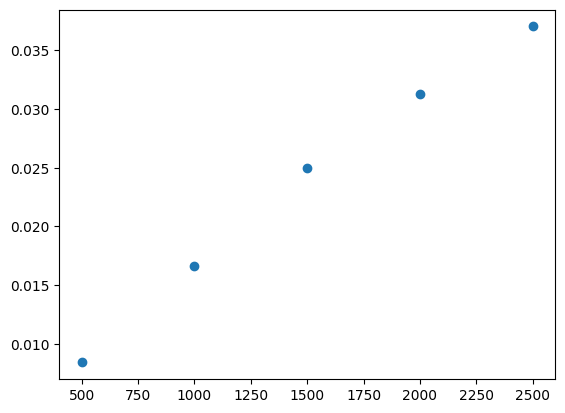

In [82]:
x = [500, 1000, 1500, 2000, 2500]
y = [find_freq('gray2_ch1.jpg'), find_freq('gray_ch1.jpg'), find_freq('gray3_ch1.jpg'), find_freq('gray4_ch1.jpg'), find_freq('gray5_ch1.jpg')]

plt.scatter(x, y)

<div dir="ltr">
     Now, according to the graphs above, we can see that the relationship between the frequency and the size (height) of the photos is linear, so by applying a linear relationship to the numbers we obtained, we can get a relationship to get the frequency and use it.
</div>

In [83]:
a, b = np.polyfit(x, y, 1)
Y = [a * i + b for i in x]
print(a, b)

1.4370136943666355e-05 0.002116207594148755


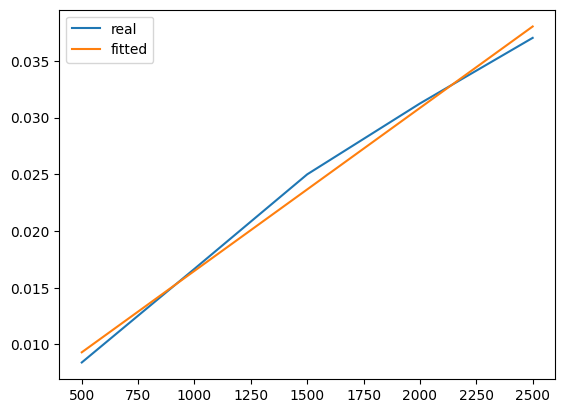

In [85]:
plt.plot(x, y, label = 'real')
plt.plot(x, Y, label = 'fitted')

plt.legend(loc='best')

<div dir="ltr">
     Now, to remove noise from the photos, we use the following relationship, and since the phase of the noise is variable and cannot be obtained, here we apply a renodom phase to the photo and add this noise to the photo and input We are trying to cancel the noise by superimposing these two effects on the channel. Finally, you can see the results on three photos.
</div>

In [89]:
def denoise(image_path):
    image = cv.imread(image_path, cv.IMREAD_COLOR)
    
    height, width, _ = image.shape
    de = np.zeros((height, width))
    F = a * height + b
    phase = 2*np.pi*np.random.rand()
    for i in range(width):
        de[:, i] = int(-41 * np.sin((2 * np.pi * i * F) + phase))

    de = de.astype(np.uint8)
    for i in range(3):
        image[:, :, i] += de
    image = np.mod(image, 256)
    cv.imwrite(image_path.split('.')[0] + '_dech1.jpg', image)

In [90]:
denoise('1.jpg')
denoise('2.jpg')
denoise('3.jpg')

In [91]:
!python "C:\Users\pc_iran\Desktop\Signal&Systems_Project\Final Project Signals and Systems_v3\channel1.cpython-311.pyc" "C:\Users\pc_iran\Desktop\Signal&Systems_Project\Final Project Signals and Systems_v3\1_dech1.jpg"
!python "C:\Users\pc_iran\Desktop\Signal&Systems_Project\Final Project Signals and Systems_v3\channel1.cpython-311.pyc" "C:\Users\pc_iran\Desktop\Signal&Systems_Project\Final Project Signals and Systems_v3\2_dech1.jpg"
!python "C:\Users\pc_iran\Desktop\Signal&Systems_Project\Final Project Signals and Systems_v3\channel1.cpython-311.pyc" "C:\Users\pc_iran\Desktop\Signal&Systems_Project\Final Project Signals and Systems_v3\3_dech1.jpg"

<div dir="rtl">
    <img src="1_dech1_ch1.jpg" alt="Drawing" style="width: 400px;"/><br>
    <img src="2_dech1_ch1.jpg" alt="Drawing" style="width: 400px;"/><br>
    <img src="3_dech1_ch1.jpg" alt="Drawing" style="width: 400px;"/><br>
   
</div>

<div dir="ltr">
     As you can see, although the noises have not completely disappeared here, but their superposition can be seen, which is more clear in the first photo, which has been neutralized in some spots and the photo has returned to normal. But in some other places, the resulting photo has also caused the noise to intensify. These cases are also true for the second and third photos.
</div>

<div dir="ltr">

It's impossible, isn't it? Because the width of the noise source always changes. So, in order to cancel this noise, we have to send the signal several times and pray that in one of the transmissions, the noise and our additional changes will be in phase with the signal. Calculate the mathematical hope of the number of times we need to send the signal so that our mean square error is less than 2%.

</div>

<div dir="ltr">
First, we need to find the probability that the sum of two sinusoidal signals leads to an mse error of less than 2% of the maximum value of the 256 signal. For this purpose, if we consider the sum of two sinusoids with different phases: <br>
     $$Asin(2\pi fx + \phi_1) + Asin(2\pi fx + \phi_2) = 2(\frac{A}{2}sin(2\pi fx + \frac{\phi_1 + \phi_2} {2} + \frac{\phi_1 - \phi_2}{2}) + \frac{A}{2}sin(2\pi fx + \frac{\phi_1 + \phi_2}{2} + \frac{\ phi_2 - \phi_1}{2})) = $$
     $$2Acos(\frac{\phi_1 - \phi_2}{2})sin(2\pi fx + \frac{\phi_1 + \phi_2}{2})$$
     Now, in this case, to get the mse error, we must use the average power of the new signal, which: <br>
     $$mse = \sqrt{p} = \sqrt{\frac{1}{T} \int_{t = 0}^{T} |x(t)|^2 dt}$$
     Considering that the mean power value of sinusoidal noise is equal to $\frac{1}{2}$, in this case the mse error will be equal to: <br>
     $$mse= A\sqrt{2}|cos(\frac{\phi_1 - \phi_2}{2})| \le 0.02A$$
     In this case, the value of the interval for the difference of two phases is equal to: <br>
     $$178.37 < |\phi_1 - \phi_2| < 181.62$$
         Now, if we consider the length of the interval for the difference of two phases to be 360 degrees, the final probability is equal to: <br>
         $$P_{superposition} = 0.009$$
         Now, considering that every time here we add sinusoidal noise so that this possibility of superposition occurs, here we can use a geometric distribution that we obtained the probability of success and we know that its mathematical hope is equal to:
         $$E[n] = 1/p = 111$$
         Therefore, it can be roughly said that if we add the signal on average about 111 times, superposition occurs with the desired error interval.
</div>

<div dir="ltr">

### Second and third channels:<br>
These channels are not color sensitive. Compare channel input and output in the frequency domain to find out more. To show your comparison, you can use a heatmap or display your compared numbers on an image. Write your answer in full below.

</div>

<div dir="ltr">
     First, I pass all three given photos along with a completely random photo created in noisy.jpg through both channels and save the results. In order to be able to compare them in frequency space. For them I create a map with this relationship: <br>
     $$min(\frac{|x - y|}{|x|}, \frac{|x - y|}{|y|})$$
     where x and y are two separate frequency components in a color channel. In the following, you can see the photos of all these maps for the second and third channels and for Hechhar, and the minimum and maximum changes in their frequency are also shown:
</div>

In [3]:
def dct_2d(matrix):
    return dct(dct(matrix, axis = 0), axis = 1)

def idct_2d(matrix):
    height, width = matrix.shape
    return idct(idct(matrix, axis = 0), axis=1)/2/width/2/height

In [6]:
def create_map(ch1, ch2):
    map = np.minimum(np.abs(ch1 - ch2)/np.abs(ch1), np.abs(ch1 - ch2)/np.abs(ch2))
    map = (map / (np.max(map) - np.min(map))) * 255
    map = map.astype(np.uint8)
    return map

def maxmin_values(ch1, ch2, channel):
    map = np.minimum(np.abs(ch1 - ch2)/np.abs(ch1), np.abs(ch1 - ch2)/np.abs(ch2))
    print(f'max values for channel {channel} is: {np.max(map)}')
    print(f'min values for channel {channel} is: {np.min(map)}')

In [19]:
noisy = np.random.randint(low = 0, high = 255, size=(3000, 3000, 3))
cv.imwrite('noisy.jpg', noisy)

True

In [ ]:
!python "C:\Users\pc_iran\Desktop\Signal&Systems_Project\Final Project Signals and Systems_v3\channel2.cpython-311.pyc" "C:\Users\pc_iran\Desktop\Signal&Systems_Project\Final Project Signals and Systems_v3\1.jpg"
!python "C:\Users\pc_iran\Desktop\Signal&Systems_Project\Final Project Signals and Systems_v3\channel2.cpython-311.pyc" "C:\Users\pc_iran\Desktop\Signal&Systems_Project\Final Project Signals and Systems_v3\2.jpg"
!python "C:\Users\pc_iran\Desktop\Signal&Systems_Project\Final Project Signals and Systems_v3\channel2.cpython-311.pyc" "C:\Users\pc_iran\Desktop\Signal&Systems_Project\Final Project Signals and Systems_v3\3.jpg"
!python "C:\Users\pc_iran\Desktop\Signal&Systems_Project\Final Project Signals and Systems_v3\channel2.cpython-311.pyc" "C:\Users\pc_iran\Desktop\Signal&Systems_Project\Final Project Signals and Systems_v3\noisy.jpg"


!python "C:\Users\pc_iran\Desktop\Signal&Systems_Project\Final Project Signals and Systems_v3\channel3.cpython-311.pyc" "C:\Users\pc_iran\Desktop\Signal&Systems_Project\Final Project Signals and Systems_v3\1.jpg"
!python "C:\Users\pc_iran\Desktop\Signal&Systems_Project\Final Project Signals and Systems_v3\channel3.cpython-311.pyc" "C:\Users\pc_iran\Desktop\Signal&Systems_Project\Final Project Signals and Systems_v3\2.jpg"
!python "C:\Users\pc_iran\Desktop\Signal&Systems_Project\Final Project Signals and Systems_v3\channel3.cpython-311.pyc" "C:\Users\pc_iran\Desktop\Signal&Systems_Project\Final Project Signals and Systems_v3\3.jpg"
!python "C:\Users\pc_iran\Desktop\Signal&Systems_Project\Final Project Signals and Systems_v3\channel3.cpython-311.pyc" "C:\Users\pc_iran\Desktop\Signal&Systems_Project\Final Project Signals and Systems_v3\noisy.jpg"

<div dir = "ltr">
    
## Check the first photo

In [25]:
image = cv.imread('1.jpg', cv.IMREAD_COLOR)
image2 = cv.imread('1_ch2.jpg', cv.IMREAD_COLOR)
image3 = cv.imread('1_ch3.jpg', cv.IMREAD_COLOR)


r, g, b = dct_2d(image[:, :, 0]), dct_2d(image[:, :, 1]), dct_2d(image[:, :, 2])

r2, g2, b2 = dct_2d(image2[:, :, 0]), dct_2d(image2[:, :, 1]), dct_2d(image2[:, :, 2])

r3, g3, b3 = dct_2d(image3[:, :, 0]), dct_2d(image3[:, :, 1]), dct_2d(image3[:, :, 2])

max values for channel red is: 1.9999975522657727
min values for channel red is: 4.213774500956422e-08
max values for channel green is: 1.999999856152196
min values for channel green is: 4.416526086380188e-08
max values for channel blue is: 1.9999999481901165
min values for channel blue is: 3.396132074727624e-08


(-0.5, 3022.5, 3442.5, -0.5)

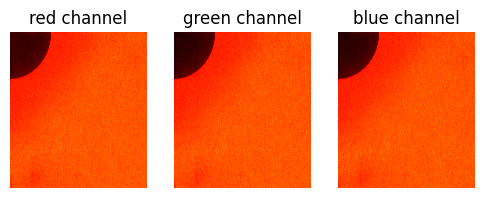

In [26]:
fig = plt.figure(figsize = (3 * 2, 1 * 10))

fig.add_subplot(1, 3, 1)
plt.imshow(create_map(r, r2), cmap='hot')
maxmin_values(r, r2, 'red')
plt.title('red channel')
plt.axis('off')


fig.add_subplot(1, 3, 2)
plt.imshow(create_map(g, g2), cmap='hot')
maxmin_values(g, g2, 'green')
plt.title('green channel')
plt.axis('off')


fig.add_subplot(1, 3, 3)
plt.imshow(create_map(b, b2), cmap='hot')
maxmin_values(b, b2, 'blue')
plt.title('blue channel')
plt.axis('off')

max values for channel red is: 1.9999975522657727
min values for channel red is: 4.213774500956422e-08
max values for channel green is: 1.999999856152196
min values for channel green is: 4.416526086380188e-08
max values for channel blue is: 1.9999999481901165
min values for channel blue is: 3.396132074727624e-08


(-0.5, 3022.5, 3442.5, -0.5)

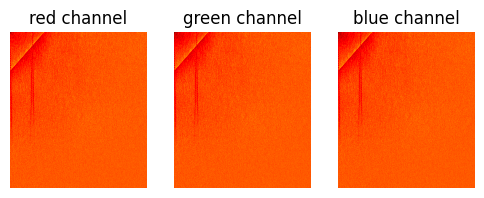

In [27]:
fig = plt.figure(figsize = (3 * 2, 1 * 10))

fig.add_subplot(1, 3, 1)
plt.imshow(create_map(r, r3), cmap='hot')
maxmin_values(r, r2, 'red')
plt.title('red channel')
plt.axis('off')


fig.add_subplot(1, 3, 2)
plt.imshow(create_map(g, g3), cmap='hot')
maxmin_values(g, g2, 'green')
plt.title('green channel')
plt.axis('off')


fig.add_subplot(1, 3, 3)
plt.imshow(create_map(b, b3), cmap='hot')
maxmin_values(b, b2, 'blue')
plt.title('blue channel')
plt.axis('off')

<div dir = "ltr">
    
## Check the second photo


In [9]:
image = cv.imread('2.jpg', cv.IMREAD_COLOR)
image2 = cv.imread('2_ch2.jpg', cv.IMREAD_COLOR)
image3 = cv.imread('2_ch3.jpg', cv.IMREAD_COLOR)


r, g, b = dct_2d(image[:, :, 0]), dct_2d(image[:, :, 1]), dct_2d(image[:, :, 2])

r2, g2, b2 = dct_2d(image2[:, :, 0]), dct_2d(image2[:, :, 1]), dct_2d(image2[:, :, 2])

r3, g3, b3 = dct_2d(image3[:, :, 0]), dct_2d(image3[:, :, 1]), dct_2d(image3[:, :, 2])

max values for channel red is: 1.9999840973121716
min values for channel red is: 2.760469755332621e-05
max values for channel green is: 1.9997133646939746
min values for channel green is: 2.373986032146789e-06
max values for channel blue is: 1.9996793231213421
min values for channel blue is: 3.0156830644288657e-05


(-0.5, 258.5, 193.5, -0.5)

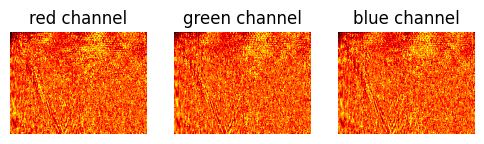

In [10]:
fig = plt.figure(figsize = (3 * 2, 1 * 10))

fig.add_subplot(1, 3, 1)
plt.imshow(create_map(r, r2), cmap='hot')
maxmin_values(r, r2, 'red')
plt.title('red channel')
plt.axis('off')


fig.add_subplot(1, 3, 2)
plt.imshow(create_map(g, g2), cmap='hot')
maxmin_values(g, g2, 'green')
plt.title('green channel')
plt.axis('off')


fig.add_subplot(1, 3, 3)
plt.imshow(create_map(b, b2), cmap='hot')
maxmin_values(b, b2, 'blue')
plt.title('blue channel')
plt.axis('off')

max values for channel red is: 1.9999840973121716
min values for channel red is: 2.760469755332621e-05
max values for channel green is: 1.9997133646939746
min values for channel green is: 2.373986032146789e-06
max values for channel blue is: 1.9996793231213421
min values for channel blue is: 3.0156830644288657e-05


(-0.5, 258.5, 193.5, -0.5)

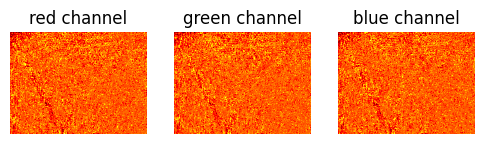

In [11]:
fig = plt.figure(figsize = (3 * 2, 1 * 10))

fig.add_subplot(1, 3, 1)
plt.imshow(create_map(r, r3), cmap='hot')
maxmin_values(r, r2, 'red')
plt.title('red channel')
plt.axis('off')


fig.add_subplot(1, 3, 2)
plt.imshow(create_map(g, g3), cmap='hot')
maxmin_values(g, g2, 'green')
plt.title('green channel')
plt.axis('off')


fig.add_subplot(1, 3, 3)
plt.imshow(create_map(b, b3), cmap='hot')
maxmin_values(b, b2, 'blue')
plt.title('blue channel')
plt.axis('off')

<div dir = "ltr">
    
## check the third photo


In [12]:
image = cv.imread('3.jpg', cv.IMREAD_COLOR)
image2 = cv.imread('3_ch2.jpg', cv.IMREAD_COLOR)
image3 = cv.imread('3_ch3.jpg', cv.IMREAD_COLOR)


r, g, b = dct_2d(image[:, :, 0]), dct_2d(image[:, :, 1]), dct_2d(image[:, :, 2])

r2, g2, b2 = dct_2d(image2[:, :, 0]), dct_2d(image2[:, :, 1]), dct_2d(image2[:, :, 2])

r3, g3, b3 = dct_2d(image3[:, :, 0]), dct_2d(image3[:, :, 1]), dct_2d(image3[:, :, 2])

max values for channel red is: 1.9999453178333417
min values for channel red is: 8.415167148131075e-05
max values for channel green is: 1.9999797200854827
min values for channel green is: 3.198343524964088e-05
max values for channel blue is: 1.999626509588314
min values for channel blue is: 3.5579203885308856e-05


(-0.5, 193.5, 258.5, -0.5)

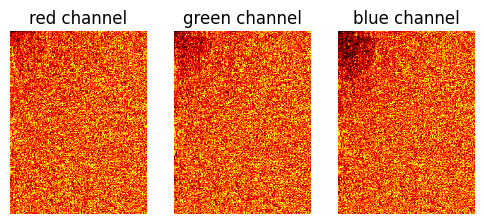

In [13]:
fig = plt.figure(figsize = (3 * 2, 1 * 10))

fig.add_subplot(1, 3, 1)
plt.imshow(create_map(r, r2), cmap='hot')
maxmin_values(r, r2, 'red')
plt.title('red channel')
plt.axis('off')


fig.add_subplot(1, 3, 2)
plt.imshow(create_map(g, g2), cmap='hot')
maxmin_values(g, g2, 'green')
plt.title('green channel')
plt.axis('off')


fig.add_subplot(1, 3, 3)
plt.imshow(create_map(b, b2), cmap='hot')
maxmin_values(b, b2, 'blue')
plt.title('blue channel')
plt.axis('off')

max values for channel red is: 1.9999453178333417
min values for channel red is: 8.415167148131075e-05
max values for channel green is: 1.9999797200854827
min values for channel green is: 3.198343524964088e-05
max values for channel blue is: 1.999626509588314
min values for channel blue is: 3.5579203885308856e-05


(-0.5, 193.5, 258.5, -0.5)

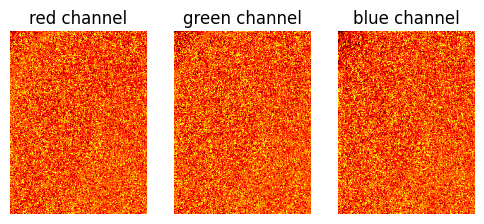

In [14]:
fig = plt.figure(figsize = (3 * 2, 1 * 10))

fig.add_subplot(1, 3, 1)
plt.imshow(create_map(r, r3), cmap='hot')
maxmin_values(r, r2, 'red')
plt.title('red channel')
plt.axis('off')


fig.add_subplot(1, 3, 2)
plt.imshow(create_map(g, g3), cmap='hot')
maxmin_values(g, g2, 'green')
plt.title('green channel')
plt.axis('off')


fig.add_subplot(1, 3, 3)
plt.imshow(create_map(b, b3), cmap='hot')
maxmin_values(b, b2, 'blue')
plt.title('blue channel')
plt.axis('off')

<div dir = "ltr">
    
## Check the fourth photo


In [15]:
image = cv.imread('noisy.jpg', cv.IMREAD_COLOR)
image2 = cv.imread('noisy_ch2.jpg', cv.IMREAD_COLOR)
image3 = cv.imread('noisy_ch3.jpg', cv.IMREAD_COLOR)


r, g, b = dct_2d(image[:, :, 0]), dct_2d(image[:, :, 1]), dct_2d(image[:, :, 2])

r2, g2, b2 = dct_2d(image2[:, :, 0]), dct_2d(image2[:, :, 1]), dct_2d(image2[:, :, 2])

r3, g3, b3 = dct_2d(image3[:, :, 0]), dct_2d(image3[:, :, 1]), dct_2d(image3[:, :, 2])

max values for channel red is: 1.9999997587904221
min values for channel red is: 1.1373247925380995e-06
max values for channel green is: 1.9999937006878792
min values for channel green is: 1.0173591605514716e-07
max values for channel blue is: 1.9999955771310078
min values for channel blue is: 2.3039394468463537e-07


(-0.5, 2999.5, 2999.5, -0.5)

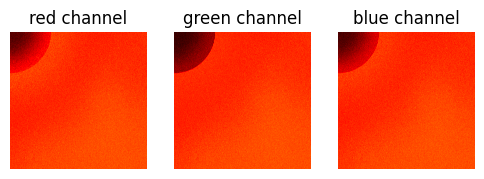

In [16]:
fig = plt.figure(figsize = (3 * 2, 1 * 10))

fig.add_subplot(1, 3, 1)
plt.imshow(create_map(r, r2), cmap='hot')
maxmin_values(r, r2, 'red')
plt.title('red channel')
plt.axis('off')


fig.add_subplot(1, 3, 2)
plt.imshow(create_map(g, g2), cmap='hot')
maxmin_values(g, g2, 'green')
plt.title('green channel')
plt.axis('off')


fig.add_subplot(1, 3, 3)
plt.imshow(create_map(b, b2), cmap='hot')
maxmin_values(b, b2, 'blue')
plt.title('blue channel')
plt.axis('off')

max values for channel red is: 1.9999997587904221
min values for channel red is: 1.1373247925380995e-06
max values for channel green is: 1.9999937006878792
min values for channel green is: 1.0173591605514716e-07
max values for channel blue is: 1.9999955771310078
min values for channel blue is: 2.3039394468463537e-07


(-0.5, 2999.5, 2999.5, -0.5)

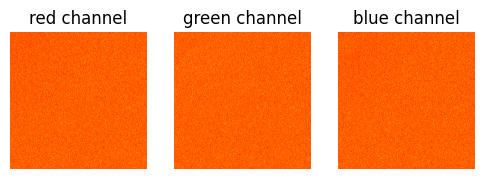

In [17]:
fig = plt.figure(figsize = (3 * 2, 1 * 10))

fig.add_subplot(1, 3, 1)
plt.imshow(create_map(r, r3), cmap='hot')
maxmin_values(r, r2, 'red')
plt.title('red channel')
plt.axis('off')


fig.add_subplot(1, 3, 2)
plt.imshow(create_map(g, g3), cmap='hot')
maxmin_values(g, g2, 'green')
plt.title('green channel')
plt.axis('off')


fig.add_subplot(1, 3, 3)
plt.imshow(create_map(b, b3), cmap='hot')
maxmin_values(b, b2, 'blue')
plt.title('blue channel')
plt.axis('off')

<div dir="ltr">
As you can see, in all the maps, the maximum amount of changes in the frequency component is equal to 2, and also for channel 2, the shape that arises is that approximately from a quarter of the width and from a quarter of the height of the frequency component in each The color channel changes and this change is almost 2 times the original value. So, for the second channel, the solution that can be suggested to eliminate the noise is to halve the value of the frequency component so that with this change we can eliminate the original noise change. <br>
     For the third channel, the amount of changes is also 2 times the original value, but the difference here is that these changes, like the changes in channel 2, have not been applied to a certain series of frequency components, and according to the results, it seems that The doubled size is randomly applied to the pixels. In this case, although we know the amount of change in the frequency component here, it cannot be reversible like channel 2 because we do not know the exact place of the change in the frequency component.

     As a result, for the second channel, we can use this function to remove the noise:
</div>

In [30]:
def denoise_ch2(image_path):
    image = cv.imread(image_path, cv.IMREAD_COLOR)
    height, width, _ = image.shape
    r, g, b = image[:, :, 0], image[:, :, 1], image[:, :, 2]
    
    r = dct_2d(r)
    g = dct_2d(g)
    b = dct_2d(b)
    
    
    for i in range(height):
        for j in range(width):
            if i > height/4 or j > width/4:
                r[i, j] *= 0.5
                g[i, j] *= 0.5
                b[i, j] *= 0.5
    
    r = idct_2d(r)
    g = idct_2d(g)
    b = idct_2d(b)
    
    imp = np.stack((r, g, b), axis=2).astype(np.uint8)
    
    cv.imwrite(image_path.split('.')[0] + '_dech2.jpg', imp)

In [31]:
denoise_ch2('1.jpg')
denoise_ch2('2.jpg')
denoise_ch2('3.jpg')

In [32]:
!python "C:\Users\pc_iran\Desktop\Signal&Systems_Project\Final Project Signals and Systems_v3\channel2.cpython-311.pyc" "C:\Users\pc_iran\Desktop\Signal&Systems_Project\Final Project Signals and Systems_v3\1_dech2.jpg"
!python "C:\Users\pc_iran\Desktop\Signal&Systems_Project\Final Project Signals and Systems_v3\channel2.cpython-311.pyc" "C:\Users\pc_iran\Desktop\Signal&Systems_Project\Final Project Signals and Systems_v3\2_dech2.jpg"
!python "C:\Users\pc_iran\Desktop\Signal&Systems_Project\Final Project Signals and Systems_v3\channel2.cpython-311.pyc" "C:\Users\pc_iran\Desktop\Signal&Systems_Project\Final Project Signals and Systems_v3\3_dech2.jpg"

<div dir="rtl">
    <img src="1_dech2_ch2.jpg" alt="Drawing" style="width: 400px;"/><br>
    <img src="2_dech2_ch2.jpg" alt="Drawing" style="width: 400px;"/><br>
    <img src="3_dech2_ch2.jpg" alt="Drawing" style="width: 400px;"/><br> 
</div>

<div dir="ltr">
     As you can see the results in the first photo, there will not be much change and the same is true for the second photo. In the case of Sessom's photo, the photo will be changed. The reason for this can be considered that because the values in the photo matrix are from 0 to 255, this limitation may cause a change in dct and idct conversion, and in this case, the photo conversion cannot be done accurately.
</div>

<div dir="ltr">


### questions:


</div>

<div dir="ltr">

First question:<br>
Choose a png image with HD quality and aspect ratio. Pass it through the first channel and get its mean square error with the original image. Now convert both the original image and the noise image to jpeg and report your mean square error again. It is better to use 50 quality for compression.

</div>

In [92]:
!!python "C:\Users\pc_iran\Desktop\Signal&Systems_Project\Final Project Signals and Systems_v3\channel1.cpython-311.pyc" "C:\Users\pc_iran\Desktop\Signal&Systems_Project\Final Project Signals and Systems_v3\sample.png"

orig_image = cv.imread('sample.png', cv.IMREAD_GRAYSCALE)
noisy_image = cv.imread('sample_ch1.png', cv.IMREAD_GRAYSCALE)

print(f'mse error of channel 1: {np.sqrt(np.mean(np.abs(orig_image - noisy_image) ** 2))}')

mse error of channel 1: 10.497916459945754


In [106]:
cv.imwrite('sample.jpeg', orig_image)
cv.imwrite('sample_ch1.jpeg', noisy_image)

jpeg_comp('sample.jpeg', 'sample.txt', 50)
jpeg_comp('sample_ch1.jpeg', 'sample_ch1.txt', 50)

new_orig = jpeg_decomp('sample.txt', 'new.jpeg')
new_noisy = jpeg_decomp('sample_ch1.txt', 'sample_ch1.jpeg')

print(f'mse error of comp/decomp over channel 1: {np.mean(np.abs(new_orig - new_noisy))}')

mse error of comp/decomp over channel 1: 25.189189804932514


<div dir="ltr">

The second question:<br>
Repeat the above question for the second channel and write the result below.

</div>

In [107]:
!!python "C:\Users\pc_iran\Desktop\Signal&Systems_Project\Final Project Signals and Systems_v3\channel2.cpython-311.pyc" "C:\Users\pc_iran\Desktop\Signal&Systems_Project\Final Project Signals and Systems_v3\sample.png"

noisy_image = cv.imread('sample_ch2.png', cv.IMREAD_GRAYSCALE)

print(f'mse error of channel 2: {np.sqrt(np.mean(np.abs(orig_image - noisy_image) ** 2))}')

mse error of channel 2: 6.728716605908571


In [108]:
cv.imwrite('sample_ch2.jpeg', noisy_image)

jpeg_comp('sample_ch2.jpeg', 'sample_ch2.txt', 50)

new_orig = jpeg_decomp('sample.txt', 'new.jpeg')
new_noisy = jpeg_decomp('sample_ch2.txt', 'sample_ch2.jpeg')

print(f'mse error of comp/decomp over channel 2: {np.sqrt(np.mean(np.abs(new_orig - new_noisy) ** 2))}')

mse error of comp/decomp over channel 2: 10.338815026924134


your answer

<div dir="ltr">

The third question:
Repeat the above question for the third channel and write the result below.

</div>

In [109]:
!!python "C:\Users\pc_iran\Desktop\Signal&Systems_Project\Final Project Signals and Systems_v3\channel3.cpython-311.pyc" "C:\Users\pc_iran\Desktop\Signal&Systems_Project\Final Project Signals and Systems_v3\sample.png"

noisy_image = cv.imread('sample_ch3.png', cv.IMREAD_GRAYSCALE)

print(f'mse error of channel 3: {np.sqrt(np.mean(np.abs(orig_image - noisy_image) ** 2))}')

mse error of channel 3: 9.078087805297548


In [110]:
cv.imwrite('sample_ch3.jpeg', noisy_image)

jpeg_comp('sample_ch3.jpeg', 'sample_ch3.txt', 50)

new_orig = jpeg_decomp('sample.txt', 'new.jpeg')
new_noisy = jpeg_decomp('sample_ch3.txt', 'sample_ch3.jpeg')

print(f'mse error of comp/decomp over channel 2: {np.sqrt(np.mean(np.abs(new_orig - new_noisy) ** 2))}')

mse error of comp/decomp over channel 2: 43.182913231245905


your answer

<div dir="ltr">

The fourth question:
By comparing the above results, say which category of noises is removed more by the jpeg conversion reconstruction error and which category does it reconstruct well?

</div>

<div dir = "ltr">
According to the results obtained here, in the third channel, the noise error increases more than the other channels after passing through the channel, and in the second channel, this error is less than the others.
</div>